In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statistics import stdev
import statsmodels
from statsmodels.sandbox.stats.multicomp import multipletests
import imblearn
import sys
from numpy import mean, absolute, sqrt
import scipy.stats
import sklearn.linear_model
import sklearn.neighbors
import sklearn.preprocessing
from xgboost import XGBClassifier
import sklearn.ensemble
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.naive_bayes import GaussianNB
from itertools import combinations, cycle
import time

def handle_scale_and_nan(df):
    features = list(df.select_dtypes(include='float64'))
    cat = list(df.select_dtypes(include='object'))
    scaler = sklearn.preprocessing.StandardScaler().fit(df[features])
    df_cont = pd.DataFrame(data=scaler.transform(df[features]), columns=features)
    df_cat = pd.DataFrame(data=df[cat], columns=cat)
    df = pd.concat([df_cat,df_cont],axis=1)
    df = df.fillna(value=0.01)
    
    return df

def split_cats_by_tolerance(
    frame,
    tolerance,
    silent=False,
    randomstate=None,
    split=0.15,
    step=1,
    target="group",
    categories=["Healthy", "AD_MCI", "PD", "PD_MCI_LBD"],
):
    tolerable_list = []
    if randomstate == None:
        randomstate = np.random.randint(0, 2**31)
    elif type(randomstate) == int:
        pass
    while sum(tolerable_list) != 4:
        df_dev, df_test = sklearn.model_selection.train_test_split(
            frame, test_size=split, random_state=randomstate
        )

        dev_dict = dict(df_dev[target].value_counts())
        test_dict = dict(df_test[target].value_counts())

        tolerable_list = []
        stats_dict = {}
        for i in range(0, len(categories)):
            try:
                percents = [
                    (dev_dict[categories[i]] / len(df_dev)),
                    (test_dict[categories[i]] / len(df_test)),
                ]
            except:
                break
            standdev = np.std(percents)
            if standdev <= tolerance:
                tolerable_list.append(1)
                stats_dict[str(categories[i])] = [[*percents], standdev]
            else:
                tolerable_list.append(0)

        randomstate += step

    if sum(tolerable_list) == 4:
        if silent == False:
            print(dev_dict)
            print(test_dict)
            print("Randstate:", randomstate - 1)
            for i in range(0, len(categories)):
                print(
                    "\nPercent",
                    categories[i],
                    "in dev, test:",
                    stats_dict[categories[i]][0],
                    "\nStandard deviation of these values:",
                    stats_dict[categories[i]][1],
                    "\n",
                )
        elif silent == True:
            pass

    return df_dev, df_test

def over_under(df_train,cat_in_excess='Healthy',target='group',randomstate=np.random.randint(0,4294967295)):
    """
    Takes dataframe(s) with only the target value and float64 features
    This function is to balance the samples in an imbalanced training dataset that has one category in excess, with additional categories more near each other
    The categories below the category in excess will be oversampled to equality, then the category in excess will be undersampled to equality
    ---Parameters---
    df_train: the training dataframe
    cat_in_excess: the category which is present in excess, far above the other categories
    target: target column in the dataframe
    randomstate: if chosen, this will the random state for the sampling. Default: None, numpy random integer method between 0 and 4294967295, the range of the sampling module used
    randomstate_sampler: the number of loops to run to compare random states starting from 
    """
    # Drop the excessive category and oversample minority to the intermediate category
    df_train_no_excess = df_train[df_train.group != cat_in_excess]
    over_sampler = imblearn.over_sampling.RandomOverSampler(random_state=randomstate)
    X_train = df_train_no_excess.drop(columns=target)
    y_train = df_train_no_excess[target]
    X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)
    df_train_over = pd.concat([y_train_over,X_train_over],axis=1)

    # Re-introduce the excessive category and undersample the majority to the minority
    df_train_excess = pd.concat([df_train_over,df_train[df_train[target] == cat_in_excess]])
    under_sampler = imblearn.under_sampling.RandomUnderSampler(random_state=randomstate)
    X_train = df_train_excess.drop(columns=target)
    y_train = df_train_excess[target]
    X_train_under, y_train_under = under_sampler.fit_resample(X_train,y_train)
    df_train_eq = pd.concat([y_train_under,X_train_under],axis=1)
    
    return df_train_eq

def select_features(data_dev, n):
    X_dev = data_dev.iloc[:, 1:-1]
    y_dev = data_dev.iloc[:, 0]
    
    from sklearn.datasets import make_classification
    X, y = make_classification(n_samples = 100, n_features = 20, n_informative = 2, n_redundant = 2)
    X = pd.DataFrame(X_dev)
    y = pd.Series(y_dev)
    
    from mrmr import mrmr_classif
    feature_list = mrmr_classif(X=X, y=y, K=n)
    print(feature_list)
    
    import json
    aList = feature_list
    jsonStr = json.dumps(aList)
    
    jsonFile = open("mRMR_"+ str(n)+ "_features.json", "w")
    jsonFile.write(jsonStr)
    jsonFile.close()
    
    return feature_list

def apply_ml_model(dev,classifier,scoring_method='balanced_accuracy', cv=10, feature_list=None):
    """
    Finds the score for different ML classifiers
    Takes a dataframe with only target and feature columns
    dev : the development dataframe with a single categorical target column and float64 features
    classifier: ML classifier to test.
        options: "random_forest', "naive_bayes", "decision_tree"
    scoring_method: method of scoring the classifier
        run sklearn.metrics.get_scorer_names() to get a list of scoring methods
    target: target categorical column
    cv: folds to run in evaluation. takes integers or 'max': will run maximum number of folds = # of samples in categories
    """
    if feature_list is None:
        feature_list = selected_features
        
    # define predictor and response variables
    X = dev[feature_list]
    y = dev['group'].values.reshape(-1,1)
    
    # check that the data has equal number of categories in training data
    counts_list = list(dev['group'].value_counts())
    assert len(set(counts_list)) == 1, 'training data should contain equal quantities of categories. run bp_preprocessing.over_under() or other balancer'
    
    
    # choose model based on user input
    if classifier == "random_forest": 
        model = sklearn.ensemble.RandomForestClassifier()
    elif classifier == "naive_bayes":  
        model = sklearn.naive_bayes.GaussianNB()
    elif classifier == "decision_tree": 
        model = sklearn.tree.DecisionTreeClassifier()
    elif classifier == "xgboost": 
        model = XGBClassifier()
    else: 
        print("wrong classifier named entered")
    #define cv quantity:
    if type(cv) == int:
        pass
    elif cv == 'max':
        cv = counts_list[0]
    else:
        raise TypeError('Enter an integer or "max" as a string')
        
    scores = cross_val_score(model, X, y, scoring=scoring_method,cv=cv)
    mean_score = np.mean(abs(scores))
    std = np.std(scores)
    stats_list = [cv, scores, mean_score, std , model, scoring_method, feature_list[-2:]]
    stats_df = pd.DataFrame(data=[stats_list], columns=['folds','scores','abs_avg_score','std','model','scoring_method', 'features'])
    
    return stats_df

def make_confusion_mtrx(dev, df_test, feature_list=None):
    if feature_list is None:
        feature_list = selected_features
        
    test_X = df_test[feature_list]
    test_y = df_test['group']

    dev_X = dev[feature_list]
    dev_y = dev.iloc[:,0] # 0th column is our target

    model = sklearn.ensemble.RandomForestClassifier()
    model.fit(dev_X, dev_y) 
    print('score=', sklearn.metrics.balanced_accuracy_score(test_y, model.predict(test_X)))
    ConfusionMatrixDisplay.from_estimator(model, test_X, test_y)
    plt.show()

In [2]:
dev = pd.read_csv('/Users/katherine/Desktop/data_with_biomarkers.csv',
                       sep='\t')

In [3]:
dev = handle_scale_and_nan(dev)

In [4]:
dev, test = split_cats_by_tolerance(dev,0.01,randomstate=98281)

{'Healthy': 132, 'AD_MCI': 43, 'PD_MCI_LBD': 32, 'PD': 31}
{'Healthy': 24, 'AD_MCI': 8, 'PD_MCI_LBD': 5, 'PD': 5}
Randstate: 98281

Percent Healthy in dev, test: [0.5546218487394958, 0.5714285714285714] 
Standard deviation of these values: 0.008403361344537785 


Percent AD_MCI in dev, test: [0.18067226890756302, 0.19047619047619047] 
Standard deviation of these values: 0.004901960784313722 


Percent PD in dev, test: [0.13025210084033614, 0.11904761904761904] 
Standard deviation of these values: 0.005602240896358551 


Percent PD_MCI_LBD in dev, test: [0.13445378151260504, 0.11904761904761904] 
Standard deviation of these values: 0.007703081232492998 



In [5]:
train, val = split_cats_by_tolerance(dev,0.01,randomstate=98281)

{'Healthy': 112, 'AD_MCI': 37, 'PD_MCI_LBD': 27, 'PD': 26}
{'Healthy': 20, 'AD_MCI': 6, 'PD': 5, 'PD_MCI_LBD': 5}
Randstate: 98450

Percent Healthy in dev, test: [0.5544554455445545, 0.5555555555555556] 
Standard deviation of these values: 0.0005500550055005382 


Percent AD_MCI in dev, test: [0.18316831683168316, 0.16666666666666666] 
Standard deviation of these values: 0.008250825082508254 


Percent PD in dev, test: [0.12871287128712872, 0.1388888888888889] 
Standard deviation of these values: 0.0050880088008800894 


Percent PD_MCI_LBD in dev, test: [0.13366336633663367, 0.1388888888888889] 
Standard deviation of these values: 0.002612761276127612 



In [6]:
train = over_under(train,cat_in_excess='Healthy',target='group',randomstate=np.random.randint(0,4294967295))

In [7]:
feature_list = select_features(train, 18)

100%|███████████████████████████████████████████| 18/18 [00:01<00:00, 14.30it/s]

['TAU', 'ACTBM', 'CEMIP', 'OLM2A', 'PCDAD', '1433G', 'CADH5', 'COSA1', 'SPRN', 'VWF', 'AB42/AB40', 'SERC', 'PAL4A', 'CO7', 'GUAD', 'BMAL2', 'SYT11', 'PGK1']


In [8]:
apply_ml_model(train,classifier='random_forest',scoring_method='balanced_accuracy', cv=10, feature_list = feature_list)

,folds,scores,abs_avg_score,std,model,scoring_method,features
0,10,"[0.7083333333333334, 0.7291666666666666, 0.937...",0.739583,0.124391,RandomForestClassifier(),balanced_accuracy,"[SYT11, PGK1]"


score= 0.4541666666666666


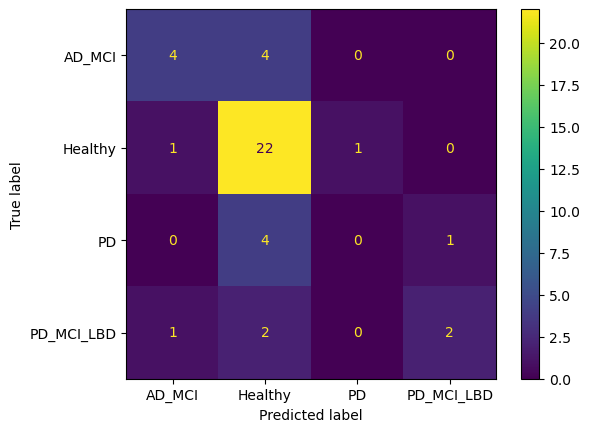

In [9]:
make_confusion_mtrx(dev, test, feature_list)